In [421]:
import numpy as np
import matplotlib.pyplot as plt

define constants

In [422]:
sample_rate = 1e6 
N = 100 # number of observations
d= 0.5 # Half Wavelengh 
Nr = 6# Number of sensors
t = np.arange(N)/sample_rate # time vector

defenition of  signal w/ given doa, aml-e, and freq

In [423]:
def create_signal(theta_deg, amplitude, f_tone):
    x = (amplitude)*np.exp(2j * np.pi * f_tone * t)
    s = np.exp(-2j * np.pi * d * np.arange (Nr) * np.sin(theta_deg/180*np.pi))
    s = s.reshape(-1, 1) #column vector
    x = x.reshape(1, -1) #row vector
    X = s @ x #create steered signal X (N x Nr)
    return X

Below our "stimulus" is created

In [424]:
f_tone = 0.02e6 #tone frequency
tx = 1*np.exp(2j * np.pi * f_tone * t)
tx2 = 2*np.exp(2j * np.pi * f_tone*2 * t)
theta_deg = 50 # direction of arrival 
theta_deg2 = 2 # direction of arrival 
theta_deg3 = -10 # direction of arrival 
X1 = create_signal(theta_deg, 1, 0.12e6 )
X2 = create_signal(theta_deg2,1, 0.52e6 )
X3 = create_signal(theta_deg3, 1, 0.32e6 )

n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)

X = X2 + 0.00003*n  # X and n are both NrxN
Xsum = np.sum(X, 0)/Nr
print(Xsum.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension

(100,)


Visualising...

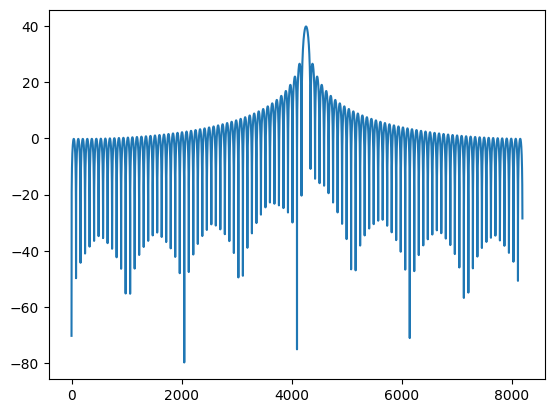

In [425]:
plt.plot(10*np.log10(np.abs(np.fft.fft(Xsum, 8192))**2))
plt.show()

1. Initalize algorithm with:
    
    $P(0) = {1 \over \sigma_o^2}I$, I is Identity matrix

    $w(0) = v_s/N$ , 
    
    or $w(0) = w_q$

2. At each snapshot $K = 1, 2, ...$ update 

    $g(K) = {\mu^{-1} P(K-1) X(K) \over 1+ \mu^{-1} X^H(K) P(K-1) X(K)} $ , and

    $P(K) = \mu^{-1}P(K-1) - \mu^{-1} g(K) X^H(K) P(K-1)$
    
    $\Lambda(K) = [v_s^H P(K) v_s]^{-1}$


3.  $Y(K) = w_{mpdr}^H(K-1) X(K)$
4.  $w_{mpdr} = {\Lambda(K) \over \mu \Lambda(K-1)} [w_{mpdr}(K-1) - g(k) Y^*(K)]$


In [426]:
def mvdr_rls(mu, sigma_o_square, X, vs):
    mu_inv = 1 / mu
    P = (1 / sigma_o_square)*np.eye(Nr) #P(0)
    wq = vs/Nr # w(0)
    Lambda = 1/(vs.conj().T @ P @ vs)
    Lambda_prev = Lambda
    #print (Lambda)
    w_mvdr = wq
    Pk = P
    XX = X.T
    Yk = 0 + 0j
    for k in range(len(X[0])):
        Xk = XX[k]
        #step 1: update g(k)
        gk = (mu_inv * Pk @ Xk) / (1 + mu_inv * Xk.conj().T @ Pk @ Xk)
        #step 2: update P(k)
        Pk = mu_inv * Pk - mu_inv * gk @ Xk.conj().T * Pk
        #step 3: update Lambda(k)
        Lambda = 1/(vs.conj().T @ Pk @ vs)
        #step 4: compute w_mvdr 
        Yk = w_mvdr.conj().T @ Xk
        w_mvdr = (Lambda/(mu * Lambda_prev))*(w_mvdr - gk * Yk.conj())
        Lambda_prev = Lambda
    ##end for##
    return w_mvdr


perform RLS implementation of LSE algorithm

In [427]:
mu = 0.95
sigma_o_sqr = 0.01
vs = np.ones(Nr)
w = mvdr_rls(mu, sigma_o_sqr, X, vs)
w = w.reshape(1, -1)
w = w.conj()
print(w)


[[18201.48071804+89308.38711752j 10293.51129749+54037.23412342j
   6350.84746962+18065.63815639j  6362.49672245-18075.76140699j
  10304.51322171-54022.04477796j 18165.83372122-89321.27460852j]]


polar coordinates plot

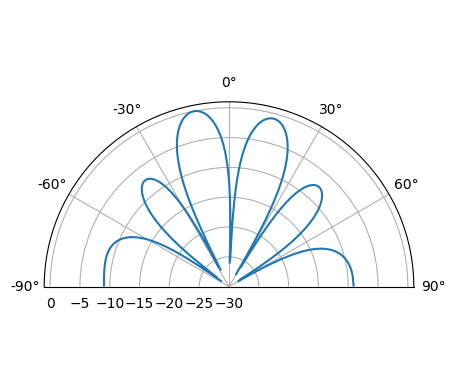

In [428]:
N_fft = 512

w_padded = np.concatenate((w[0], np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB

plt.show()

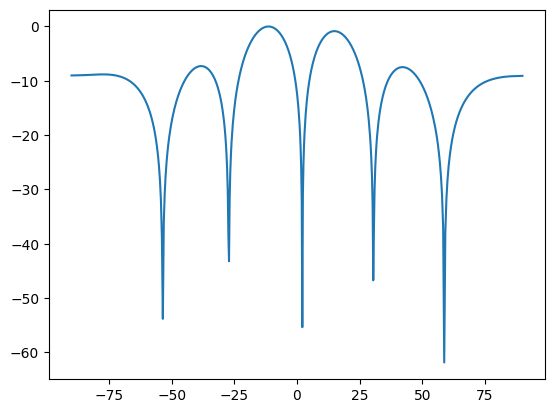

In [429]:
theta_scan = np.arcsin(np.linspace(-1, 1, N_fft))
plt.plot(theta_scan*180/np.pi, w_fft_dB)
plt.show()

(1, 100)


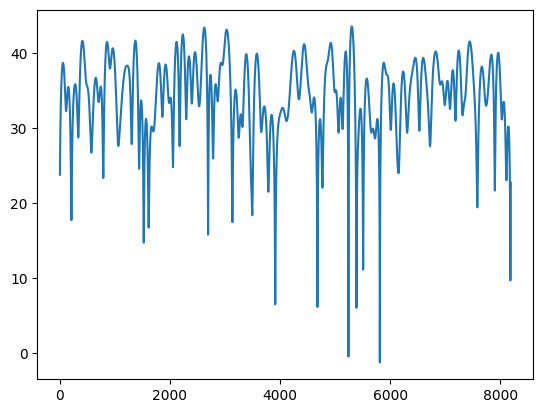

In [430]:
Y = w @ X #w is already conjugated
print(Y.shape)
plt.plot(10*np.log10(np.abs(np.fft.fft(Y[0],8192))**2))
plt.show()